 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/3.%20Preprint%20Percentage%20Analysis.ipynb#Data-Loading-and-Preprocessing" data-toc-modified-id="Data-Loading-and-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Loading and Preprocessing</a></span></li><li><span><a href="http://localhost:8888/notebooks/3.%20Preprint%20Percentage%20Analysis.ipynb#Main-Plot:-Percentage-of-Prepublications-by-Year-and-Area" data-toc-modified-id="Main-Plot:-Percentage-of-Prepublications-by-Year-and-Area-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Main Plot: Percentage of Prepublications by Year and Area</a></span></li><li><span><a href="http://localhost:8888/notebooks/3.%20Preprint%20Percentage%20Analysis.ipynb#For-each-venue,-prepublication-percentage-in-2017-(dotplot-grouped-by-area)" data-toc-modified-id="For-each-venue,-prepublication-percentage-in-2017-(dotplot-grouped-by-area)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>For each venue, prepublication percentage in 2017 (dotplot grouped by area)</a></span></li><li><span><a href="http://localhost:8888/notebooks/3.%20Preprint%20Percentage%20Analysis.ipynb#Was-arxiv-submission-before-or-after-blind-review?" data-toc-modified-id="Was-arxiv-submission-before-or-after-blind-review?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Was arxiv submission before or after blind review?</a></span></li><li><span><a href="http://localhost:8888/notebooks/3.%20Preprint%20Percentage%20Analysis.ipynb#Table-of-all-areas-and-venues-considered" data-toc-modified-id="Table-of-all-areas-and-venues-considered-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Table of all areas and venues considered</a></span></li><li><span><a href="http://localhost:8888/notebooks/3.%20Preprint%20Percentage%20Analysis.ipynb#Total-number-of-conferences-and-areas-considered" data-toc-modified-id="Total-number-of-conferences-and-areas-considered-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Total number of conferences and areas considered</a></span></li></ul></div>

This notebook generates all of the results from the paper

**TODO** update citation  Sutton and Gong. Popularity of Arxiv Among Computer Scientists. 2017.
  
Before running this notebook, you need to have the collected and preprocessed data in the `generated/` subdirectory. A version of this data is available for download from

**TODO**  add link
  
The main analysis is contained in the notebook below. If you want to drill down futher, you should read these other notebooks:

 * Notebook to [download and preprocess](0.%20Download%20and%20Preprocess%20Data.ipynb) data from Arxiv and DBLP
 * Notebook to [exploratory analysis]() to sanity check processed data
 * Notebook to [validate record linkage]() between Arxiv and DBLP
 

# Data Loading and Preprocessing

In [1]:
%matplotlib inline
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import json
import colorcet as cc

from dblp import config

/Users/csutton/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
 glob.glob ('generated/matching/*')

['generated/matching/all-papers-matched-titleauthor.json',
 'generated/matching/bak',
 'generated/matching/small-papers.json',
 'generated/matching/subset__close.json',
 'generated/matching/subset__matched.json']

In [3]:
matched_file = 'generated/matching/all-papers-matched-titleauthor.json'

In [4]:
with open (matched_file) as f:
    matches = json.load (f)
    
records = [ {'area': d['area'], 'venue': d['venue'], 'year': d['year'], 'preprint': int('arxiv' in d), 'url': d.get('url', None) } for d in matches ]
df = pd.DataFrame (records)

In [5]:
df.head()

,area,preprint,url,venue,year
0,bio,0,db/journals/bioinformatics/bioinformatics29.ht...,ISMB,2013
1,bio,0,db/journals/bioinformatics/bioinformatics30.ht...,ISMB,2014
2,bio,0,db/journals/bioinformatics/bioinformatics26.ht...,ISMB,2010
3,bio,0,db/journals/bioinformatics/bioinformatics25.ht...,ISMB,2009
4,bio,0,db/journals/bioinformatics/bioinformatics29.ht...,ISMB,2013


Some modifications to how we consider the venues before analysis.

CSrankings.org treats KDD and ICML/NIPS as being part of the same research area. For our analysis, we do not want to do this, as the data mining and machine learning communities seem to have different norms regarding prepublication. We also exclude bioinformatics from our analysis, as we expect that many bioinformatics preprints will appear on bioRxiv rather than Arxiv.org.

In [6]:
df.loc[df["venue"] == "KDD", "area"] = "mining"
df.loc[df["venue"] == "ICML", "area"] = "ml"
df.loc[df["venue"] == "NIPS", "area"] = "ml"
df = df[df.area != "bio"]

It will help to have the inverse map from venues to areas.

In [7]:
v2a = dict()
a2v = dict()
for v,a in zip(df["venue"], df["area"]):
    if (v in v2a) and (v2a[v] != a):
        print ("Error: multiply defined {} and {} both go to {}".format (v, a, v2a[v]))
    v2a[v] = a
    
    venues = a2v.get(a, [])
    if v not in venues:
        venues.append(v)
        a2v[a] = venues

The data frame that we have above contains 1 row for each publication that we consider. For analysis we'll need to aggregate that by year, by research area, and by venue.

In [8]:
year_df = df.groupby(['year'], as_index=False).agg({ 'preprint':
                      { 'total': 'count',
                       'matched': 'sum'
                  } })
area_df = df.groupby(['area', 'year'], as_index=False).agg({ 'preprint':
                      { 'total': 'count',
                       'matched': 'sum'
                  } })
venue_df = df.groupby(['venue', 'year'], as_index=False).agg({ 'preprint':
                      { 'total': 'count',
                       'matched': 'sum'
                  } })


area_df = area_df.set_index("area")
venue_df = venue_df.set_index("venue")

area_df['On Arxiv (%)'] = area_df['preprint', 'matched'] / area_df['preprint', 'total']
venue_df['On Arxiv (%)'] = venue_df['preprint', 'matched'] / venue_df['preprint', 'total']
year_df['On Arxiv (%)'] = year_df['preprint', 'matched'] / year_df['preprint', 'total']

area_df.columns = [ "Year", "Papers", "On Arxiv", "On Arxiv (%)"  ]
venue_df.columns = [ "Year", "Papers", "On Arxiv", "On Arxiv (%)"  ]
year_df.columns = [ "Year", "Papers", "On Arxiv", "On Arxiv (%)"  ]


/Users/csutton/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


For convenience, create smaller data frames that have the most recent year.

In [9]:
area16_df = area_df[area_df.Year == 2016]
area17_df = area_df[area_df.Year == 2017]
venue17_df = venue_df[venue_df.Year == 2017]

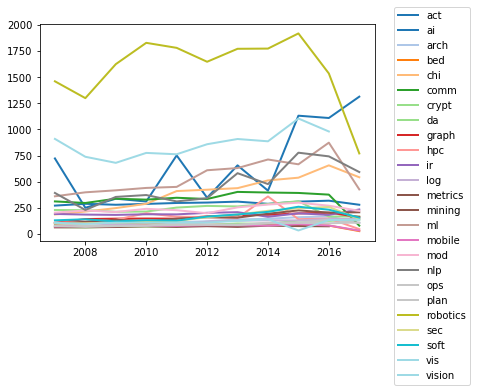

In [10]:
groups = area_df.groupby('area')
labels = []
colors = plt.cm.tab20(np.linspace(0, 1, len(groups)))

i = 0
for grp,df0 in groups:
    plt.plot(df0['Year'], df0['Papers'], linewidth=2.0, linestyle='-', color=colors[i])
    i += 1
    labels.append(grp)
ax = plt.gca()
ax.legend(labels, bbox_to_anchor=(1.3,1.1))
plt.show()


# Main Plot: Percentage of Prepublications by Year and Area

There are going to be a lot of lines in the next plot, so we'll go to a lot of effort to set up the colormaps intelligently. We'll colour the top 10 research areas differently from the rest.

In [11]:
Ntop = 9
areas_sorted = area16_df.sort_values("On Arxiv (%)", ascending=False)
top10_areas = areas_sorted.index[0:Ntop]
next10_areas = areas_sorted.index[Ntop:(2*Ntop)]
other_areas = areas_sorted.index[(2*Ntop):len(areas_sorted.index)]

Set up the colormaps so that the lines for the top 10 areas are multicoloured, and the others are in grayscale.

In [12]:
top_colors = plt.cm.Set1(np.linspace(0,1, len(top10_areas)))
next_colors = plt.cm.Set2(np.linspace(0.25,1, len(next10_areas)))
other_colors = plt.cm.Pastel1(np.linspace(0,0.25, len(other_areas)))
area_colors = dict ( list(zip(top10_areas, top_colors)) + list(zip(next10_areas, next_colors)) + list(zip(other_areas, other_colors))  )

area_styles = dict ()
for area in top10_areas: area_styles[area] = '-'
for area in next10_areas: area_styles[area] = 'dashed'
for area in other_areas: area_styles[area] = 'dotted'

In [13]:
area_styles

{'act': '-',
 'ai': '-',
 'arch': 'dotted',
 'bed': 'dotted',
 'chi': 'dotted',
 'comm': 'dashed',
 'crypt': 'dashed',
 'da': 'dotted',
 'graph': 'dotted',
 'hpc': 'dashed',
 'ir': '-',
 'log': '-',
 'metrics': '-',
 'mining': '-',
 'ml': '-',
 'mobile': 'dashed',
 'mod': 'dashed',
 'nlp': '-',
 'ops': 'dotted',
 'plan': 'dashed',
 'robotics': 'dashed',
 'sec': 'dashed',
 'soft': 'dashed',
 'vis': 'dotted',
 'vision': '-'}

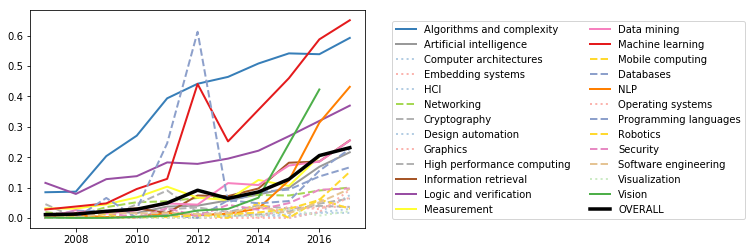

In [14]:
for grp,df0 in area_df.groupby('area'):
    plt.plot(df0['Year'], df0["On Arxiv (%)"], linewidth=2.0, linestyle=area_styles[grp], color=area_colors[grp], label=config.labeldict[grp])

plt.plot(year_df['Year'], year_df["On Arxiv (%)"], linewidth=3.5, color='black', label="OVERALL")

ax = plt.gca()
ax.legend(bbox_to_anchor=(2.15,0.975), ncol=2)
plt.savefig("figures/arxiv_pct_by_area.pdf", format="pdf", bbox_inches="tight")
plt.show()

The clear 2012 outlier in the above graph is databases:

In [15]:
for grp,df0 in area_df.groupby('area'):
    if grp == "mod":
        print (df0)

      Year  Papers  On Arxiv  On Arxiv (%)
area                                      
mod   2007     205         1      0.004878
mod   2008     225         5      0.022222
mod   2009     211         5      0.023697
mod   2010     241         7      0.029046
mod   2011     228        56      0.245614
mod   2012     199       122      0.613065
mod   2013     255        13      0.050980
mod   2014     282        24      0.085106
mod   2015     300        28      0.093333
mod   2016     271        37      0.136531
mod   2017     222        37      0.166667


In 2012, we seem to have both many fewer databases papers in our arxiv than in other years, and an unusally high number of matched papers. To see why that is, let's drill down to the individual venues.

First, SIGMOD 2012 has about 30 fewer accepted papers than the surrounding years. Going back to DBLP seems to indicate that this is accurate and not an artifact of our processing.

In [16]:
venue_df.loc["SIGMOD"]

,Year,Papers,On Arxiv,On Arxiv (%)
venue,,,,
SIGMOD,2007,88,1,0.011364
SIGMOD,2008,101,1,0.009901
SIGMOD,2009,83,0,0.000000
SIGMOD,2010,92,2,0.021739
SIGMOD,2011,96,0,0.000000
SIGMOD,2012,60,1,0.016667
SIGMOD,2013,89,5,0.056180
SIGMOD,2014,120,7,0.058333
SIGMOD,2015,144,5,0.034722


VLDB seems to have had a one year uptick in the number of matched papers, which looks unusal.

In [17]:
venue_df.loc["PVLDB"]

,Year,Papers,On Arxiv,On Arxiv (%)
venue,,,,
PVLDB,2007,117,0,0.000000
PVLDB,2008,124,4,0.032258
PVLDB,2009,128,5,0.039062
PVLDB,2010,149,5,0.033557
PVLDB,2011,132,56,0.424242
PVLDB,2012,139,121,0.870504
PVLDB,2013,166,8,0.048193
PVLDB,2014,162,17,0.104938
PVLDB,2015,156,23,0.147436


We'll dump the list of all papers for further analysis.

In [18]:
vldb2012 = [ m  for m in matches if ((m["venue"] == "PVLDB") and (m["year"] == 2012)) ]
with open("vldb2012.json", "w") as f:
    json.dump(vldb2012, f, indent=2)

We manually selected a few papers from this dump to examine. This examination did not reveal any false positives in our matching algorithm between Arxiv and DBLP. We did notice that all of the PVLDB 2012 papers that we reviewed had the metadata from the VLDB publication entered into Arxiv. As authors are not always assiduous at doing this on their own, it is possible that the high rate of Arxiv submissions for PVLDB 2012 was the result of actions taken by the conference organizers that year.

How has the total preprint usage in computer science changes over the past 10 years? We see that preprint percentage has **quadrupled** in five years.

In [19]:
year_df

,Year,Papers,On Arxiv,On Arxiv (%)
0,2007,6542,71,0.010853
1,2008,5719,72,0.012590
2,2009,6337,137,0.021619
3,2010,6788,194,0.028580
4,2011,7315,359,0.049077
5,2012,7222,658,0.091110
6,2013,8207,528,0.064335
7,2014,8346,713,0.085430
8,2015,9650,1229,0.127358
9,2016,9319,1914,0.205387


In [20]:
print ("Median preprint pct across areas (2017) = {:.3f}".format (np.median(area17_df["On Arxiv (%)"])))
area17_df.sort_values("On Arxiv (%)", ascending=False);

Median preprint pct across areas (2017) = 0.097


In [21]:
print ("Median preprint pct across venues (2017) = {:.3f}".format (np.median(venue17_df["On Arxiv (%)"])))

Median preprint pct across venues (2017) = 0.117


Let's create a table for all of the 2017 venues that have more than 10 papers on arxiv.

In [22]:
top17 = (venue17_df.sort_values("On Arxiv (%)", ascending=False))
top17 = top17[top17["On Arxiv"] >= 10]
top17 = top17.drop("Year", 1)
top17

,Papers,On Arxiv,On Arxiv (%)
venue,,,
ICML,427,278,0.651054
STOC,98,63,0.642857
SODA,182,103,0.565934
ACL,290,133,0.458621
EMNLP,303,123,0.405941
LICS,85,33,0.388235
CAV,61,21,0.344262
POPL,64,19,0.296875
WWW,158,44,0.278481


# For each venue, prepublication percentage in 2017 (dotplot grouped by area)

Generate a dotplot that for each area, shows the arxiv % over the conferences in that area. This lets us see the variance across venues in the same area.

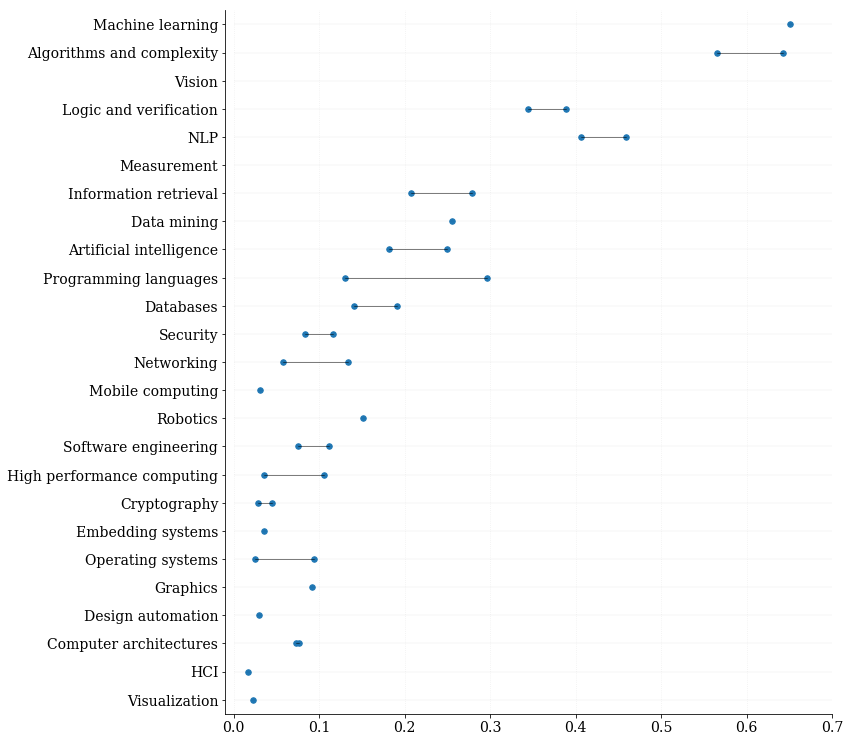

In [23]:
# via https://acaird.github.io/2016/06/24/dotplots-with-matplotlib

areas = list(area_df.index.unique())
areas.sort(key=lambda area: float(area16_df.loc[area, "On Arxiv (%)"]))
area2int = dict([ (areas[i], i) for i in range(len(areas))])

# font size 
font = {'family' : 'serif',
        'size'   : 14}
matplotlib.rc('font', **font)

# Get the plot aspect right for thinner bars that aren't too spread out
fig, ax = plt.subplots(figsize=(12,10.5))
ax.patch.set_visible(False)

# all the points we want to plot
ys_all = [ area2int[v2a[v]] for v in venue17_df.index ]
xs_all = venue17_df["On Arxiv (%)"]

# Create the bars
# The parameters are:
#   - the number of bars for the y-axis
#   - the values from the first column of data
#   - the width of the bars out to the points
#   - color = the color of the bars
#   - edgecolor = the color of the bars' borders
#   - alpha = the transparency of the bars
for i in range(len(areas)):
    plt.plot([0.0, 1.0], [i, i], color='k', linestyle='-', alpha=0.4, linewidth=0.1)
    venue_vals = xs_all.loc[list(pd.Series(ys_all) == i)]
    if len(venue_vals) > 1:
        plt.plot([min(venue_vals), max(venue_vals)], [i, i], color='k', linestyle='-', linewidth=0.5)

# Create the points using normal x-y scatter coordinates
# The parameters are:
#   - the x values from the first column of the data
#   - the y values, which are just the indices of the data
#   - the size of the points
points = ax.scatter(xs_all, ys_all, s=30)


ax.set_xlim([-0.01,0.7])
ax.set_ylim([-0.5, len(areas)-0.5])
ax.set_yticks(range(len(areas)))
ax.set_yticklabels([ config.labeldict[a] for a in areas ])

# Turn off all of the borders
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)

# Turn on the X (vertical) gridlines
ax.xaxis.grid(True, linestyle='dotted', alpha=0.2)

plt.tight_layout(True)

plt.savefig("figures/areas_dotplot.pdf", format="pdf")

# Was arxiv submission before or after blind review?

Authors could have submitted their papers:
 
  * Before the conference deadline. (Could be years before, especially in the case of a paper that had been rejected from a previous years' conference)
  * After the submission deadline but before the camera ready deadline
  * After the camera ready deadline but before the conference
  
For arxiv papers that have multiple revisions, we use the date of the first revision as the submission date of the arxiv paper.
  
For the year 2017, we collected the submission deadline, camera-ready deadline and first date of the conference from all the conferences; this was collected retrospectively by visiting the conference web sites on 20-21 September 2017. SIGMOD 2017 had an opportunity for revision during the review process; the date of the final accept/reject decision was used as the notification deadline.

We collect the dates only for those venues that had at least 10 Arxiv papers in 2017. PLVDB was excluded from this analysis due to its rolling deadlines. This left us with 16 venues to examine, with a total of 1324 matched arxiv papers.

In [24]:
big_venues = venue17_df[(venue17_df["On Arxiv"] >= 10)]

In [25]:
big_venues

,Year,Papers,On Arxiv,On Arxiv (%)
venue,,,,
AAAI,2017,661,165,0.249622
ACL,2017,290,133,0.458621
CAV,2017,61,21,0.344262
EMNLP,2017,303,123,0.405941
FSE,2017,90,10,0.111111
ICML,2017,427,278,0.651054
ICRA,2017,771,117,0.151751
IJCAI,2017,653,119,0.182236
KDD,2017,208,53,0.254808


In [26]:
len(big_venues)

18

In [27]:
sum(big_venues['On Arxiv'])

1349

The deadlines that were collected from manual web searching are in the file `data/deadlines.csv`.

In [28]:
deadlines = pd.read_csv("data/deadlines.csv")
deadlines = deadlines.set_index("venue")

In some cases, the date of notification was unavailable from a web search:
* For ICML 2017, the notification date was taken from the date of the author notification email that CS recieved from the conference. 
* For SODA 2017, the notification deadline was taken to be 1 October 2016 as an approximation based on a statement made https://www.siam.org/meetings/da17/proceedings.php: "SIAM will provide final paper submission instructions to authors of accepted papers in early October 2016". 
* For ICRA 2017, the notification date was unavailable so the camera-ready date was used instead.

In [29]:
deadlines.loc["ICRA", "notification"] = deadlines.loc["ICRA", "camera_ready"] 


For each conference, we measure the percentage of arxiv articles that are preprints, i.e., the submission date to Arxiv is prior to the notification date of the conference.

First, we go back to the original JSON dump of DBLP, and keep only those articles that are in our target conferences, come from 2017, and are paired to arxiv.

In [30]:
our_venues = list(deadlines.index)
dblp_with_arxiv = [ art for art in matches if ('arxiv' in art) and (art['venue'] in our_venues) and (art['year'] == 2017) ]

Sanity check that the number of articles matches our number from above.

In [31]:
len(dblp_with_arxiv)

1302

A few short of the number above, but that is probably reasonable because we excluded PVLDB from this analysis, and not the number above.    

To do the join between notification dates, the DBLP, and the arxiv, it will be useful to convert the deadlines data frame into a Python dict that maps conference names --> notification deadlines. Here's a three liner to do that.

In [32]:
cnf2not = deadlines.to_dict()["notification"]
cnf2sub = deadlines.to_dict()["submission"]

Now load our arxiv dump from JSON and create an index that lets us map an arxiv id to the JSON metadata for the article.

In [33]:
with open ("generated/arxiv/json/arxiv_articles.json") as f:
    arxiv = json.load (f)

arxiv_dict = dict()
for art in arxiv:
    arxiv_dict[art['id']] = art

In [34]:
arxiv[1]

{'authors': 'I. Csiszar, F. Hiai and D. Petz',
 'bow_authors': [['i', 'csiszar'], ['f', 'hiai'], ['d', 'petz']],
 'bow_title': ['limit',
  'relation',
  'entropy',
  'channel',
  'capacity',
  'per',
  'unit',
  'cost'],
 'category': 'quant-ph cs.IT math.IT',
 'id': '0704.0046',
 'submit': '1-Apr-2007',
 'title': 'A limit relation for entropy and channel capacity per unit cost',
 'year': 2007}

We define a function that does the string->date object conversion so that we can chronologically compare two dates that are expressed as strings.

In [35]:
import time
def lte_date_strings (date1, date2):
    newdate1 = time.strptime(date1, "%d-%b-%Y") 
    newdate2 = time.strptime(date2, "%d-%b-%Y")
    return newdate1 <= newdate2

Now here's our loop that does the join between arxiv articles, dblp articles, and conference deadlines. The output is four different lists:
 * `all_preprints`: List of all dblp articles who were submitted before the conference notification deadline
 * `num_preprints`: Dictionary that maps venue name --> number of arxiv articles that were submitted before notification deadline ("genuine preprints")
 * `all_presub`: List of all dblp articles who were submitted before the conference submission deadline
 * `num_presub`: Dictionary that maps venue name --> number of arxiv articles that were submitted before conference submission deadline ("presubmission arxiv")

In [36]:
import itertools

all_preprints = list()
num_preprints = dict(zip (our_venues, itertools.repeat(0, len(our_venues))))
all_presub = list()
num_presub = dict(zip (our_venues, itertools.repeat(0, len(our_venues))))

for dblp_art in dblp_with_arxiv:
    arxiv_art = arxiv_dict[dblp_art["arxiv"][0]]
    venue = dblp_art["venue"]
    if lte_date_strings( arxiv_art["submit"], cnf2not [venue]):
        num_preprints[venue] += 1
        all_preprints.append(dblp_art)
    if lte_date_strings( arxiv_art["submit"], cnf2sub [venue]):
        num_presub[venue] += 1
        all_presub.append(dblp_art)

Quick sanity check: Does sum(num_preprints) = len(all_preprints) and same for presub?

In [37]:
num_preprints

{'AAAI': 82,
 'ACL': 26,
 'CAV': 10,
 'EMNLP': 45,
 'ICML': 204,
 'ICRA': 84,
 'IJCAI': 51,
 'KDD': 35,
 'LICS': 22,
 'POPL': 10,
 'SIGIR': 0,
 'SIGMOD': 8,
 'SODA': 81,
 'STOC': 49,
 'WWW': 24}

In [38]:
len(all_preprints)

731

In [39]:
sum([v for k,v in num_preprints.items()])

731

In [40]:
num_presub

{'AAAI': 56,
 'ACL': 16,
 'CAV': 6,
 'EMNLP': 28,
 'ICML': 95,
 'ICRA': 20,
 'IJCAI': 30,
 'KDD': 15,
 'LICS': 8,
 'POPL': 1,
 'SIGIR': 0,
 'SIGMOD': 7,
 'SODA': 47,
 'STOC': 24,
 'WWW': 9}

In [41]:
len(all_presub)

362

In [42]:
sum([v for k,v in num_presub.items()])

362

In [43]:
aaai_preprints = [ art for art in all_preprints if art["venue"] == "AAAI" ]

In [44]:
aaai_preprints[1]

{'area': 'ai',
 'arxiv': ['1604.03635'],
 'authors': ['Anton Milan',
  'Seyed Hamid Rezatofighi',
  'Anthony R. Dick',
  'Ian D. Reid 0001',
  'Konrad Schindler'],
 'bow_authors': [['anton', 'milan'],
  ['seyed', 'hamid', 'rezatofighi'],
  ['anthony', 'r', 'dick'],
  ['ian', 'd', 'reid', '0001'],
  ['konrad', 'schindler']],
 'dblp': 'conf/aaai/MilanRD0S17',
 'title': 'Online Multi-Target Tracking Using Recurrent Neural Networks',
 'url': 'db/conf/aaai/aaai2017.html#MilanRD0S17',
 'venue': 'AAAI',
 'year': 2017}

In [45]:
arxiv_dict["1604.03635"]

{'authors': 'Anton Milan, Seyed Hamid Rezatofighi, Anthony Dick, Ian Reid, Konrad Schindler',
 'bow_authors': [['anton', 'milan'],
  ['seyed', 'hamid', 'rezatofighi'],
  ['anthony', 'dick'],
  ['ian', 'reid'],
  ['konrad', 'schindler']],
 'bow_title': ['online',
  'multi',
  'target',
  'tracking',
  'using',
  'recurrent',
  'neural',
  'networks'],
 'category': 'cs.CV',
 'id': '1604.03635',
 'submit': '13-Apr-2016',
 'title': 'Online Multi-Target Tracking Using Recurrent Neural Networks',
 'year': 2016}

Now we can produce the headline numbers:
    
* 56% of the accepted CS papers submitted to Arxiv were true preprints, in that they were submitted to Arxiv before the conference notification deadline.
* 28% of the accepted CS papers submitted to Arxiv were submitted even before the conference submission deadline, a total of 361 papers. These may indicate papers that were previously rejected from other conferences, or simply papers for which a draft was posted well in advance of the deadline.

In [46]:
len(all_preprints) / len(dblp_with_arxiv)

0.5614439324116743

In [47]:
len(all_presub) / len(dblp_with_arxiv)

0.2780337941628264

Also let's plot the variation in preprint and presubmission areas across the different venues.

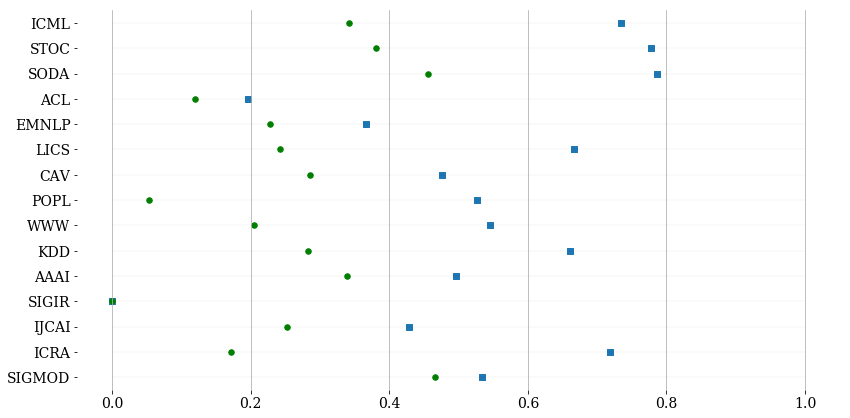

In [48]:
# via https://acaird.github.io/2016/06/24/dotplots-with-matplotlib


sorted_venues = sorted(our_venues, key=lambda venue: float(venue17_df.loc[venue, 'On Arxiv (%)']) )
venue2int = dict([ (sorted_venues[i], i) for i in range(len(our_venues))])

# Get the plot aspect right for thinner bars that aren't too spread out
fig, ax = plt.subplots(figsize=(12,6))
ax.patch.set_visible(False)

# Create the bars
# The parameters are:
#   - the number of bars for the y-axis
#   - the values from the first column of data
#   - the width of the bars out to the points
#   - color = the color of the bars
#   - edgecolor = the color of the bars' borders
#   - alpha = the transparency of the bars
for i in range(len(sorted_venues)):
    plt.plot([0.0, 1.0], [i, i], color='k', linestyle='-', alpha=0.4, linewidth=0.1)

# Create the points using normal x-y scatter coordinates
# The parameters are:
#   - the x values from the first column of the data
#   - the y values, which are just the indices of the data
#   - the size of the points
ys = [ venue2int[venue] for venue in sorted_venues ]
xs = [ num_preprints[venue] / (venue17_df.loc[venue]["On Arxiv"]) for venue in sorted_venues ]
points = ax.scatter(xs, ys, s=30, marker="s")

xs = [ num_presub[venue] / (venue17_df.loc[venue]["On Arxiv"]) for venue in sorted_venues ]
points = ax.scatter(xs, ys, s=30, color="green")

ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.5, len(sorted_venues)-0.5])
ax.set_yticks(range(len(sorted_venues)))
ax.set_yticklabels(sorted_venues)

# Turn off all of the borders
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Turn on the X (vertical) gridlines
ax.xaxis.grid(True)

plt.tight_layout(True)

There don't seem to be any obvious patterns that can be discerned here.

Create table for the paper that shows eprint %age and preprint %age for 2017

In [49]:
top17.head()

,Papers,On Arxiv,On Arxiv (%)
venue,,,
ICML,427,278,0.651054
STOC,98,63,0.642857
SODA,182,103,0.565934
ACL,290,133,0.458621
EMNLP,303,123,0.405941


In [50]:
num_preprints

{'AAAI': 82,
 'ACL': 26,
 'CAV': 10,
 'EMNLP': 45,
 'ICML': 204,
 'ICRA': 84,
 'IJCAI': 51,
 'KDD': 35,
 'LICS': 22,
 'POPL': 10,
 'SIGIR': 0,
 'SIGMOD': 8,
 'SODA': 81,
 'STOC': 49,
 'WWW': 24}

In [51]:
top17_mod = top17.drop("On Arxiv (%)", axis=1)
top17_mod = top17_mod.drop("PVLDB", axis=0)
for venue in top17_mod.index:
    if venue not in num_preprints:
        num_preprints[venue] = 0

top17_paper = pd.concat((top17_mod, pd.Series(num_preprints)) , axis=1, join_axes=[top17_mod.index])
top17_paper = top17_paper.reset_index()
top17_paper.columns = [ "Venue", "Papers", "e-prints", "Preprints"]
top17_paper["e-print (%)"] = 100.0 * top17_paper["e-prints"] / top17_paper['Papers']
top17_paper["Preprint (%)"] = 100.0 * top17_paper["Preprints"] / top17_paper['Papers']
top17_paper = top17_paper.loc[:, ['Venue', 'Papers', 'e-prints', 'e-print (%)', 'Preprints', 'Preprint (%)']]

top17_paper.head()

,Venue,Papers,e-prints,e-print (%),Preprints,Preprint (%)
0,ICML,427,278,65.105386,204,47.775176
1,STOC,98,63,64.285714,49,50.000000
2,SODA,182,103,56.593407,81,44.505495
3,ACL,290,133,45.862069,26,8.965517
4,EMNLP,303,123,40.594059,45,14.851485


In [52]:
with open("figures/top_venues.tex", "w") as f:
    f.write (top17_paper.to_latex(index=False, float_format="%.0f", column_format="lrrrrr"))

Ah, but the table above might look better as a dotplot.

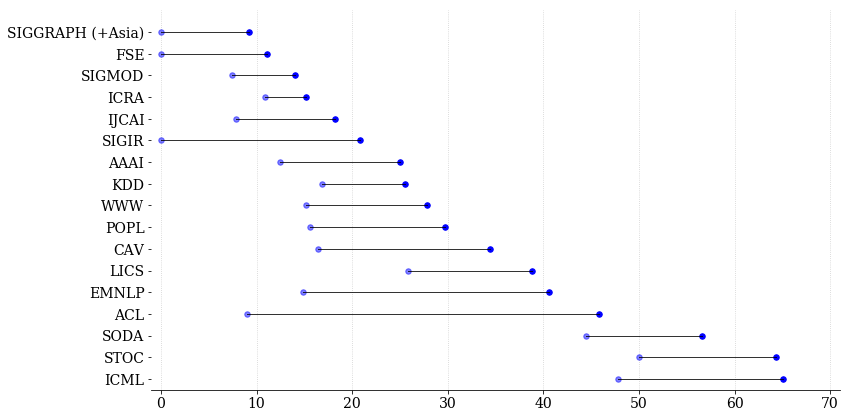

In [53]:
# via https://acaird.github.io/2016/06/24/dotplots-with-matplotlib
df = top17_paper.sort_values(by=["e-print (%)"], ascending=False)
ntopconf = len(df)

# font size 
font = {'family' : 'serif',
        'size'   : 14}
matplotlib.rc('font', **font)

# Get the plot aspect right for thinner bars that aren't too spread out
fig, ax = plt.subplots(figsize=(12,6))
ax.patch.set_visible(False)

# Create the bars
# The parameters are:
#   - the number of bars for the y-axis
#   - the values from the first column of data
#   - the width of the bars out to the points
#   - color = the color of the bars
#   - edgecolor = the color of the bars' borders
#   - alpha = the transparency of the bars
for i in range(ntopconf):
    plt.plot([df.loc[i, "Preprint (%)"], df.loc[i, "e-print (%)"]], [i,i], color='k', linestyle='-', alpha=0.8, linewidth=1)

# Create the points using normal x-y scatter coordinates
# The parameters are:
#   - the x values from the first column of the data
#   - the y values, which are just the indices of the data
#   - the size of the points
points = ax.scatter(df["Preprint (%)"], range(ntopconf), s=30, color="blue", alpha=0.5)
points = ax.scatter(df["e-print (%)"], range(ntopconf), s=30, color="blue")


ax.set_xlim([-1,71])
ax.set_ylim([-0.5, ntopconf])
ax.set_yticks(range(ntopconf))
ax.set_yticklabels(df["Venue"])

# Turn off all of the borders
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Turn on the X (vertical) gridlines
ax.xaxis.grid (color='k', linestyle='dotted', alpha=0.2)


plt.tight_layout(True)
plt.savefig("figures/preprint_dotplot.pdf", format="pdf")

# Table of all areas and venues considered

This is generated here so it can reflect some of the modifications to the venues list that we've done over the course of this notebook.

The `v2a` map was created above, while we were preparing to create the venue dotplot.

In [54]:
a2v_str = [ dict([ ('Area', config.labeldict[a]), ('Conferences', ", ".join(venues)) ]) for a,venues in a2v.items() ]

In [55]:
a2v_str

[{'Area': 'Visualization', 'Conferences': 'IEEE VIS + VR'},
 {'Area': 'Graphics', 'Conferences': 'SIGGRAPH (+Asia)'},
 {'Area': 'Databases', 'Conferences': 'PVLDB, SIGMOD'},
 {'Area': 'NLP', 'Conferences': 'ACL, HLT-NAACL, EMNLP'},
 {'Area': 'Robotics', 'Conferences': 'RSS, ICRA, IROS'},
 {'Area': 'High performance computing', 'Conferences': 'SC, ICS, HPDC'},
 {'Area': 'Mobile computing', 'Conferences': 'MobiSys, MobiCom, SenSys'},
 {'Area': 'Security', 'Conferences': 'CCS, IEEE S&P, USENIX Security'},
 {'Area': 'Measurement', 'Conferences': 'SIGMETRICS, IMC'},
 {'Area': 'Programming languages', 'Conferences': 'POPL, PLDI'},
 {'Area': 'Operating systems', 'Conferences': 'USENIX, SOSP/OSDI, EuroSys'},
 {'Area': 'Networking', 'Conferences': 'NSDI, INFOCOM, SIGCOMM'},
 {'Area': 'HCI', 'Conferences': 'UbiComp, CHI, UIST'},
 {'Area': 'Computer architectures', 'Conferences': 'MICRO, ISCA, ASPLOS'},
 {'Area': 'Embedding systems', 'Conferences': 'RTSS, RTAS, EMSOFT'},
 {'Area': 'Logic and veri

In [56]:
area_conference_df = pd.DataFrame.from_dict(a2v_str)
area_conference_df = area_conference_df.sort_values("Area", axis=0)
area_conference_df.head()

,Area,Conferences
20,Algorithms and complexity,"STOC, SODA, FOCS"
17,Artificial intelligence,"AAAI, IJCAI"
13,Computer architectures,"MICRO, ISCA, ASPLOS"
24,Cryptography,"EUROCRYPT, CRYPTO"
21,Data mining,KDD


In [57]:
with open("figures/area_conference_list.tex", "w") as f:
    f.write (area_conference_df.to_latex(index=False))

# Total number of conferences and areas considered

We consider 60 conferences over 25 subareas of computing.

In [58]:
nconf = len(v2a.keys())
narea = len(a2v.keys())
ntopconf = len(top17_paper)
print (nconf, narea, ntopconf)

60 25 17


In [59]:
cmdstring = \
'''\\newcommand{{\\nconf}}{{{}\\xspace}}
\\newcommand{{\\narea}}{{{}\\xspace}}
\\newcommand{{\\ntopconf}}{{{}\\xspace}}
'''
    
with open("figures/data_size.tex", "w") as f:
    f.write (cmdstring.format (nconf, narea, ntopconf))